# Colab C: PyTorch Class-Based 3-Layer DNN (Built-in nn.Module)

**Non-Linear Regression Using PyTorch Built-in Functionality**

---

### Key Requirements
- Uses `nn.Module` subclassing
- `nn.Linear` layers, `nn.ReLU` activations
- Built-in `torch.optim` optimizer
- Built-in `nn.MSELoss`
- Same 3-variable non-linear regression problem

## Cell 1: Import Dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch: {torch.__version__} | Device: {device}")

PyTorch: 2.10.0+cpu | Device: cpu


## Cell 2: Generate & Prepare Data

In [2]:
num_samples = 2000
x1 = np.random.uniform(-2, 2, num_samples)
x2 = np.random.uniform(-2, 2, num_samples)
x3 = np.random.uniform(-2, 2, num_samples)
y_true = np.sin(x1) * x2**2 + np.cos(x3) * x1 + 0.5 * x3 * x2

X_np = np.column_stack([x1, x2, x3]).astype(np.float32)
Y_np = y_true.reshape(-1, 1).astype(np.float32)

# Normalize
X_mean, X_std = X_np.mean(0), X_np.std(0)
Y_mean, Y_std = Y_np.mean(), Y_np.std()
X_norm = (X_np - X_mean) / X_std
Y_norm = (Y_np - Y_mean) / Y_std

X_t = torch.tensor(X_norm, device=device)
Y_t = torch.tensor(Y_norm, device=device)

# Split train/test (80/20)
split = int(0.8 * num_samples)
train_ds = TensorDataset(X_t[:split], Y_t[:split])
test_ds = TensorDataset(X_t[split:], Y_t[split:])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {split}, Test: {num_samples - split}")

Train: 1600, Test: 400


## Cell 3: 4D Data Visualization

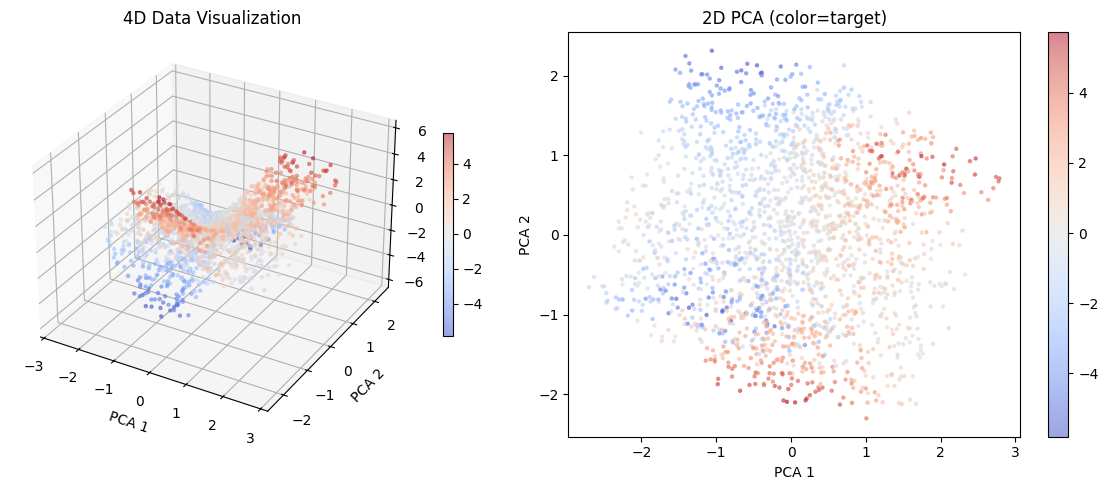

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
sc = ax1.scatter(X_pca[:, 0], X_pca[:, 1], Y_np.flatten(), c=Y_np.flatten(), cmap='coolwarm', s=5, alpha=0.5)
ax1.set_xlabel('PCA 1'); ax1.set_ylabel('PCA 2'); ax1.set_zlabel('y')
ax1.set_title('4D Data Visualization')
plt.colorbar(sc, ax=ax1, shrink=0.5)

ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_np.flatten(), cmap='coolwarm', s=5, alpha=0.5)
ax2.set_xlabel('PCA 1'); ax2.set_ylabel('PCA 2')
ax2.set_title('2D PCA (color=target)')
plt.colorbar(sc2, ax=ax2)
plt.tight_layout(); plt.show()

## Cell 4: Define Neural Network Class Using nn.Module

This uses PyTorch's built-in `nn.Linear` layers, `nn.ReLU`, and `nn.Sequential`.

In [4]:
class NonLinearRegressionNet(nn.Module):
    """3-Layer Deep Neural Network for Non-Linear Regression.

    Architecture: Input(3) -> Dense(64,ReLU) -> Dense(32,ReLU) -> Dense(16,ReLU) -> Dense(1)
    """

    def __init__(self, input_dim=3, hidden_dims=[64, 32, 16], output_dim=1):
        super(NonLinearRegressionNet, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU(),
            nn.Linear(hidden_dims[2], output_dim)
        )

        # Apply He initialization
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.network(x)

# Instantiate
model = NonLinearRegressionNet().to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

NonLinearRegressionNet(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

Total parameters: 2881


## Cell 5: Define Loss Function & Optimizer

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Loss: {criterion}")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Loss: MSELoss()
Optimizer: Adam (lr=0.001)
Trainable params: 2881


## Cell 6: Training Loop with Train/Test Tracking

In [6]:
epochs = 200
train_losses, test_losses = [], []

for epoch in range(epochs):
    # Training
    model.train()
    epoch_train_loss = 0.0
    n_train = 0
    for X_b, Y_b in train_loader:
        optimizer.zero_grad()
        pred = model(X_b)
        loss = criterion(pred, Y_b)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        n_train += 1

    # Evaluation
    model.eval()
    epoch_test_loss = 0.0
    n_test = 0
    with torch.no_grad():
        for X_b, Y_b in test_loader:
            pred = model(X_b)
            loss = criterion(pred, Y_b)
            epoch_test_loss += loss.item()
            n_test += 1

    train_losses.append(epoch_train_loss / n_train)
    test_losses.append(epoch_test_loss / n_test)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:>3}/{epochs} | Train: {train_losses[-1]:.6f} | Test: {test_losses[-1]:.6f}")

print(f"\nFinal — Train: {train_losses[-1]:.6f}, Test: {test_losses[-1]:.6f}")

Epoch   1/200 | Train: 0.639053 | Test: 0.340725
Epoch  20/200 | Train: 0.018020 | Test: 0.020711
Epoch  40/200 | Train: 0.010475 | Test: 0.011705
Epoch  60/200 | Train: 0.006368 | Test: 0.007661
Epoch  80/200 | Train: 0.003813 | Test: 0.004948
Epoch 100/200 | Train: 0.002617 | Test: 0.003774
Epoch 120/200 | Train: 0.002112 | Test: 0.002978
Epoch 140/200 | Train: 0.001913 | Test: 0.002723
Epoch 160/200 | Train: 0.001486 | Test: 0.002352
Epoch 180/200 | Train: 0.001405 | Test: 0.002277
Epoch 200/200 | Train: 0.001135 | Test: 0.002365

Final — Train: 0.001135, Test: 0.002365


## Cell 7: Plot Training & Test Loss Curves

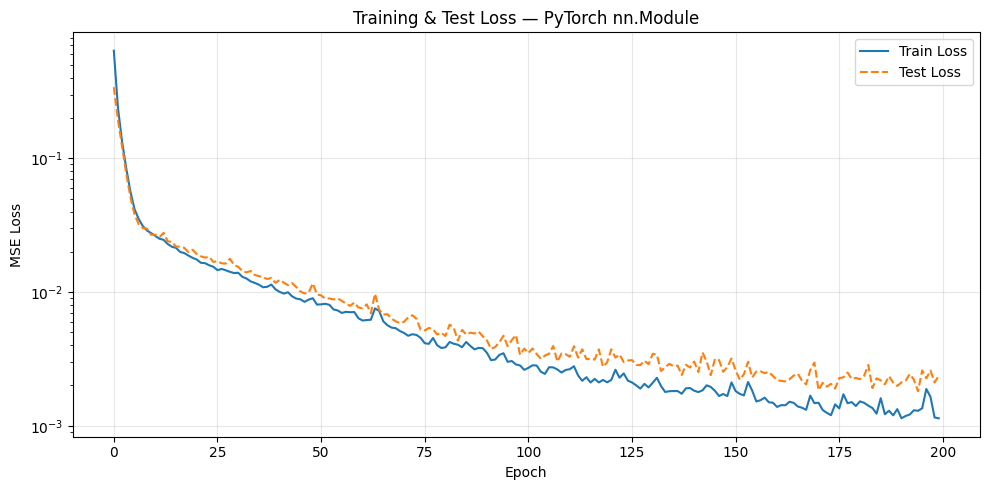

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=1.5)
plt.plot(test_losses, label='Test Loss', linewidth=1.5, linestyle='--')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.title('Training & Test Loss — PyTorch nn.Module')
plt.legend(); plt.grid(True, alpha=0.3); plt.yscale('log')
plt.tight_layout(); plt.show()

## Cell 8: Final Predictions & Visualization

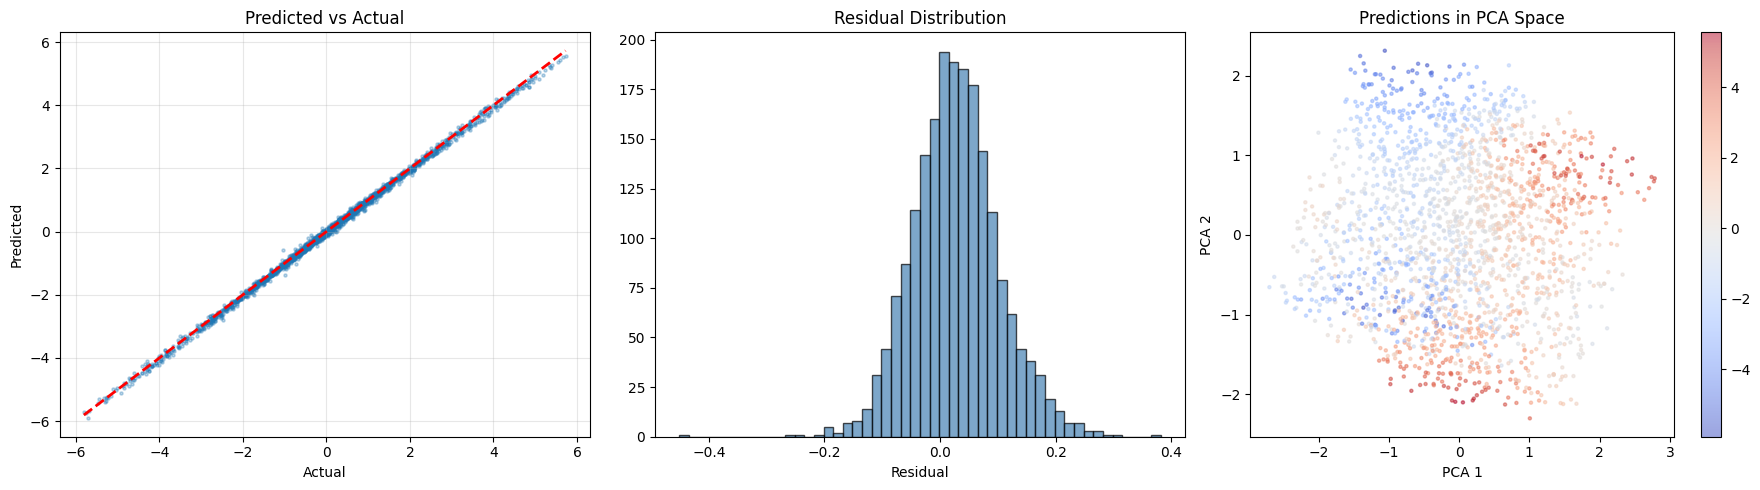

R²: 0.9983 | MAE: 0.0621 | MSE: 0.006474


In [8]:
model.eval()
with torch.no_grad():
    Y_pred_all = model(X_t).cpu().numpy()

Y_pred_denorm = Y_pred_all * Y_std + Y_mean
residuals = Y_np.flatten() - Y_pred_denorm.flatten()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(Y_np.flatten(), Y_pred_denorm.flatten(), alpha=0.3, s=5)
axes[0].plot([Y_np.min(), Y_np.max()], [Y_np.min(), Y_np.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual'); axes[0].set_ylabel('Predicted')
axes[0].set_title('Predicted vs Actual'); axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Residual'); axes[1].set_title('Residual Distribution')

sc = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred_denorm.flatten(), cmap='coolwarm', s=5, alpha=0.5)
axes[2].set_xlabel('PCA 1'); axes[2].set_ylabel('PCA 2')
axes[2].set_title('Predictions in PCA Space')
plt.colorbar(sc, ax=axes[2])
plt.tight_layout(); plt.show()

r2 = 1 - np.sum(residuals**2) / np.sum((Y_np.flatten() - Y_np.mean())**2)
print(f"R²: {r2:.4f} | MAE: {np.mean(np.abs(residuals)):.4f} | MSE: {np.mean(residuals**2):.6f}")

## Cell 9: Summary

In [9]:
print("="*60)
print("Colab C: PyTorch nn.Module Class-Based DNN — Complete!")
print("="*60)
print(f"Uses: nn.Module, nn.Linear, nn.ReLU, nn.Sequential")
print(f"Optimizer: Adam | Loss: MSELoss")
print(f"Train/Test split: 80/20")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"R²: {r2:.4f}")
print("="*60)

Colab C: PyTorch nn.Module Class-Based DNN — Complete!
Uses: nn.Module, nn.Linear, nn.ReLU, nn.Sequential
Optimizer: Adam | Loss: MSELoss
Train/Test split: 80/20
Final Train Loss: 0.001135
Final Test Loss: 0.002365
R²: 0.9983
